In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2" # GPU
os.environ["OMP_NUM_THREADS"]="4" # thread

In [3]:
import numpy as np
import pandas as pd
import math   


# 讀取訓練資料、測試資料

In [3]:
# 讀取訓練資料、測試資料
train = pd.read_csv('../input/train.csv', na_values=['', 'NULL'])
test = pd.read_csv('../input/test.csv', na_values=['', 'NULL'])

# 分別取出訓練資料的特徵和標籤
train_x = train.drop(['label','index'], axis=1)
train_y = train['label']

# 由於測試資料只有特徵，維持原樣複製一份即可
test_x = test.drop(['index'], axis=1).copy()



# 建立特徴

In [4]:
# 月份對應
month_dict = {'January': 1,
              'February': 2,
              'March':  3,
              'April':  4,
              'May': 5,
              'June':  6,
              'July':  7,
              'August':  8,
              'September':  9,
              'October': 10,
              'November':  11,
              'December':  12}

train_x["previous_connect_month"] = train_x["previous_connect_month"].map(month_dict)
test_x["previous_connect_month"] = test_x["previous_connect_month"].map(month_dict)



In [5]:
# 處理缺失值
# 全部填入眾數    
for col_name in train_x.columns:
    mode = train_x[col_name].mode()[0] 
    print(f"{col_name}的眾數 -> {mode}")
    train_x[col_name].fillna(mode, inplace=True)
    test_x[col_name].fillna(mode, inplace=True)    

age的眾數 -> 31.0
euducation_level的眾數 -> high
job的眾數 -> employment
marital的眾數 -> married
have_credit_card的眾數 -> no
have_housing_loan的眾數 -> yes
have_personal_loan的眾數 -> no
connect_method的眾數 -> cellular
previous_connect_month的眾數 -> 5.0
previous_connect_weekday的眾數 -> Thursday
campaign_connect_times的眾數 -> 1.0
after_campaign_connect_day的眾數 -> -1.0
before_campaign_connect_times的眾數 -> 0.0
last_campaign_outcomes的眾數 -> nonexistent
employment_rate的眾數 -> 61.4
consumer_price_index的眾數 -> 93.994
consumer_confidence_index的眾數 -> -36.4


In [6]:
# 類別資料 one-hot encoding

ohe_cols = ['euducation_level', 'job', 'marital', 'have_credit_card', 'have_housing_loan', 'have_personal_loan',
            'connect_method', 'previous_connect_month', 'previous_connect_weekday', 'last_campaign_outcomes']

# 整合訓練與測試資料，執行 One-hot encoding
all_x = pd.concat([train_x, test_x])
all_x = pd.get_dummies(all_x, columns=ohe_cols)

# 重新分割訓練、測試資料
train_x = all_x.iloc[:train_x.shape[0], :].reset_index(drop=True)
test_x = all_x.iloc[train_x.shape[0]:, :].reset_index(drop=True)

In [7]:
# # 數值資料 標準化
# from sklearn.preprocessing import StandardScaler

# std_cols = ['age', 'campaign_connect_times', 'after_campaign_connect_day',
#             'before_campaign_connect_times', 'employment_rate', 'consumer_price_index', 'consumer_confidence_index']

# # 結合訓練資料和測試資料並計算平均及標準差，稍後以此為基礎來進行標準化
# scaler = StandardScaler()
# scaler.fit(pd.concat([train_x[std_cols], test_x[std_cols]]))

# # 進行標準化並置換各欄位原數值

# # [取代]
# train_x[std_cols] = scaler.transform(train_x[std_cols])
# test_x[std_cols] = scaler.transform(test_x[std_cols])

# # # [附加]
# # std_train = pd.DataFrame(scaler.transform(train_x[std_cols]),
# #                          columns=[('s_'+n) for n in std_cols])
# # std_test = pd.DataFrame(scaler.transform(test_x[std_cols]),
# #                          columns=[('s_'+n) for n in std_cols])
# # # 將轉換後的 dataframe 跟其他特徵結合
# # train_x = pd.concat([train_x, std_train], axis=1)
# # test_x = pd.concat([test_x, std_test], axis=1)


In [8]:
# 數值資料 常態化
# Yeo-Johnson 轉換
from sklearn.preprocessing import PowerTransformer

pt_cols = ['age', 'campaign_connect_times', 'after_campaign_connect_day',
            'before_campaign_connect_times', 'employment_rate', 'consumer_price_index', 'consumer_confidence_index']

# 定義以訓練資料來進行多欄位的 Yeo-Johnson 轉換
pt = PowerTransformer(method='yeo-johnson')
pt.fit(pd.concat([train_x[pt_cols], test_x[pt_cols]]))

# 進行標準化並置換各欄位原數值

# [取代]
train_x[pt_cols] = pt.transform(train_x[pt_cols])
test_x[pt_cols] = pt.transform(test_x[pt_cols])

# # [附加]
# # std_train = pd.DataFrame(pt.transform(train_x[pt_cols]),
# #                          columns=[('pt_'+n) for n in pt_cols])
# # std_test = pd.DataFrame(pt.transform(test_x[pt_cols]),
# #                          columns=[('pt_'+n) for n in pt_cols])
# # # 將轉換後的 dataframe 跟其他特徵結合
# # train_x = pd.concat([train_x, std_train], axis=1)
# # test_x = pd.concat([test_x, std_test], axis=1)

In [9]:
# 特徵提取 加入PCA
from sklearn.decomposition import PCA

num_components = 3

# 定義以訓練資料來進行PCA轉換
pca = PCA(n_components=num_components)
pca.fit(np.concatenate((train_x, test_x), axis=0))

# 進行轉換 (附加)
pca_train = pd.DataFrame(pca.transform(train_x),
                         columns=[('pca_'+str(c)) for c in range(num_components)])
pca_test = pd.DataFrame(pca.transform(test_x),
                        columns=[('pca_'+str(c)) for c in range(num_components)])

# 將轉換後的 dataframe 跟其他特徵結合
train_x = pd.concat([train_x, pca_train], axis=1)
test_x = pd.concat([test_x, pca_test], axis=1)


/tmp2/r09922072/conda3/envs/py37/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/tmp2/r09922072/conda3/envs/py37/lib/python3.7/site-packages/sklearn/base.py:439: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [10]:
# 特徵提取 加入t-SNE (1)
# pip install bhtsne
import bhtsne

# 進行 t-sne 的轉換
tsne_x = np.concatenate((train_x, test_x), axis=0).astype(np.float64)
tsne_x = bhtsne.tsne(tsne_x)


Using current time as random seed...
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 0 of 39099
 - point 10000 of 39099
 - point 20000 of 39099
 - point 30000 of 39099
Input similarities computed in 71.18 seconds (sparsity = 0.003089)!
Learning embedding...
Iteration 50: error is 114.197998 (50 iterations in 34.72 seconds)
Iteration 100: error is 114.197613 (50 iterations in 46.76 seconds)
Iteration 150: error is 101.971690 (50 iterations in 41.33 seconds)
Iteration 200: error is 95.012523 (50 iterations in 41.59 seconds)
Iteration 250: error is 5.219590 (50 iterations in 46.03 seconds)
Iteration 300: error is 4.271089 (50 iterations in 43.75 seconds)
Iteration 350: error is 3.914981 (50 iterations in 44.00 seconds)
Iteration 400: error is 3.655618 (50 iterations in 45.09 seconds)
Iteration 450: error is 3.455774 (50 iterations in 47.53 seconds)
Iteration 500: error is 3.293717 (50 iterations in 49.07 seconds)
It

In [11]:
# 特徵提取 加入t-SNE (2)
tsne_train_x = tsne_x[:np.array(train_x).shape[0],:]
tsne_test_x = tsne_x[-np.array(test_x).shape[0]:,:]

print(tsne_train_x.shape)
print(tsne_test_x.shape)

# 進行轉換 (附加)
tsne_train = pd.DataFrame(tsne_train_x, columns=[('tsne_'+str(c)) for c in range(2)])
tsne_test = pd.DataFrame(tsne_test_x, columns=[('tsne_'+str(c)) for c in range(2)])

# 將轉換後的 dataframe 跟其他特徵結合
train_x = pd.concat([train_x, tsne_train], axis=1)
test_x = pd.concat([test_x, tsne_test], axis=1)


(20000, 2)
(19099, 2)


In [12]:
# 特徵提取 - UMAP 轉換 (1)
# pip install umap-learn
import umap

# 定義訓練資料的 
um = umap.UMAP()
um.fit(np.concatenate((train_x, test_x), axis=0))

# 執行轉換
um_train_x = um.transform(train_x)
um_test_x = um.transform(test_x)

In [13]:
# 特徵提取 - UMAP 轉換 (2)
print(um_train_x.shape)
print(um_test_x.shape)

# 進行轉換 (附加)
um_train = pd.DataFrame(um_train_x, columns=[('um_'+str(c)) for c in range(2)])
um_test = pd.DataFrame(um_test_x, columns=[('um_'+str(c)) for c in range(2)])

# 將轉換後的 dataframe 跟其他特徵結合
train_x = pd.concat([train_x, um_train], axis=1)
test_x = pd.concat([test_x, um_test], axis=1)

(20000, 2)
(19099, 2)


In [46]:
pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.height', 1000)
# pd.set_option('display.width', 1000)

train_x.to_csv("train_x.csv")
train_y.to_csv("train_y.csv")
test_x.to_csv("test_x.csv")
display(train_x)
display(test_x)
display(train_y)

,age,campaign_connect_times,after_campaign_connect_day,before_campaign_connect_times,employment_rate,consumer_price_index,consumer_confidence_index,euducation_level_high,euducation_level_low,euducation_level_medium,job_employment,job_retired,job_student,job_unemployed,marital_divorced,marital_married,marital_single,marital_unknown,have_credit_card_no,have_credit_card_unknown,have_credit_card_yes,have_housing_loan_no,have_housing_loan_unknown,have_housing_loan_yes,have_personal_loan_no,have_personal_loan_unknown,have_personal_loan_yes,connect_method_cellular,connect_method_telephone,previous_connect_month_3.0,previous_connect_month_4.0,previous_connect_month_5.0,previous_connect_month_6.0,previous_connect_month_7.0,previous_connect_month_8.0,previous_connect_month_9.0,previous_connect_month_10.0,previous_connect_month_11.0,previous_connect_month_12.0,previous_connect_weekday_Friday,previous_connect_weekday_Monday,previous_connect_weekday_Thursday,previous_connect_weekday_Tuesday,previous_connect_weekday_Wednesday,last_campaign_outcomes_failure,last_campaign_outcomes_nonexistent,last_campaign_outcomes_success,pca_0,pca_1,pca_2,tsne_0,tsne_1,um_0,um_1
0,0.080239,-1.064683,-0.213269,-0.43274,-0.392897,-1.970646e-15,-0.267619,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0.132510,-0.310835,0.737579,-30.859968,-3.219715,16.318945,-7.101428
1,-1.618906,0.818125,-0.213269,-0.43274,-1.217788,-2.720046e-15,-1.479867,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.531800,-2.372487,-0.812977,-7.153403,-18.102782,7.342689,-9.769300
2,-1.139916,1.166980,-0.213269,-0.43274,0.946486,4.968248e-15,-0.222932,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,-1.119437,-0.550936,-1.206746,2.339622,19.910317,-0.101933,16.632938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19997,0.629506,0.213107,-0.213269,-0.43274,0.946486,-5.828671e-16,0.960388,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,-1.109278,1.096041,-0.028019,11.776508,-3.521942,15.978269,0.906656
19998,1.226975,-1.064683,-0.213269,-0.43274,-1.522394,-3.386180e-15,-0.002723,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.605402,0.137023,1.718698,-23.111079,-10.112496,-0.436014,-1.050888
19999,0.629506,1.166980,-0.213269,-0.43274,0.946486,2.026157e-15,-0.425716,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,-1.256011,0.278673,0.265187,6.793961,23.032969,3.529915,14.209933


,age,campaign_connect_times,after_campaign_connect_day,before_campaign_connect_times,employment_rate,consumer_price_index,consumer_confidence_index,euducation_level_high,euducation_level_low,euducation_level_medium,job_employment,job_retired,job_student,job_unemployed,marital_divorced,marital_married,marital_single,marital_unknown,have_credit_card_no,have_credit_card_unknown,have_credit_card_yes,have_housing_loan_no,have_housing_loan_unknown,have_housing_loan_yes,have_personal_loan_no,have_personal_loan_unknown,have_personal_loan_yes,connect_method_cellular,connect_method_telephone,previous_connect_month_3.0,previous_connect_month_4.0,previous_connect_month_5.0,previous_connect_month_6.0,previous_connect_month_7.0,previous_connect_month_8.0,previous_connect_month_9.0,previous_connect_month_10.0,previous_connect_month_11.0,previous_connect_month_12.0,previous_connect_weekday_Friday,previous_connect_weekday_Monday,previous_connect_weekday_Thursday,previous_connect_weekday_Tuesday,previous_connect_weekday_Wednesday,last_campaign_outcomes_failure,last_campaign_outcomes_nonexistent,last_campaign_outcomes_success,pca_0,pca_1,pca_2,tsne_0,tsne_1,um_0,um_1
0,-0.994467,1.549194,-0.213269,-0.432740,0.946486,4.968248e-15,-0.222932,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-1.146730,-0.783553,-1.551005,-0.571406,10.736396,-0.641276,14.143172
1,0.868993,-1.064683,-0.213269,2.308208,-1.217788,-1.026956e-15,1.205895,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2.126512,1.462204,0.723966,24.414698,-35.189437,7.045860,3.752402
2,1.159064,0.213107,-0.213269,-0.432740,0.946486,-5.828671e-16,0.960388,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,-1.113836,1.229076,0.441030,-0.158974,2.663666,-2.418440,-6.059942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19096,0.868993,-1.064683,-0.213269,2.308208,-1.217788,-3.774758e-15,-1.255759,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2.662469,-0.195529,1.650890,30.280112,-4.636266,-1.624421,3.495118
19097,-0.855241,1.166980,-0.213269,-0.432740,0.614703,2.442491e-15,0.902449,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,-1.176333,0.062131,-1.434205,-35.550854,20.338836,-6.580408,4.916867
19098,-0.470632,0.818125,-0.213269,-0.432740,0.946486,-5.828671e-16,0.960388,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,-1.039709,0.271261,-1.361753,17.732071,-2.854004,-1.506434,6.836242


0        0
1        1
2        1
        ..
19997    0
19998    0
19999    0
Name: label, Length: 20000, dtype: int64

# 載入處理好的資料

In [4]:
# Reload Data
train_x = pd.read_csv('../input/train_x_v2.csv', na_values=['', 'NULL'])
train_y = pd.read_csv('../input/train_y_v2.csv', na_values=['', 'NULL'])
test_x = pd.read_csv('../input/test_x_v2.csv', na_values=['', 'NULL'])
test = pd.read_csv('../input/test.csv', na_values=['', 'NULL'])

In [5]:
# Feature Selection
train_x = train_x.drop(['Unnamed: 0', "tsne_0", "tsne_1"], axis=1) # 
train_y = train_y['label']
test_x = test_x.drop(['Unnamed: 0', "tsne_0", "tsne_1"], axis=1)

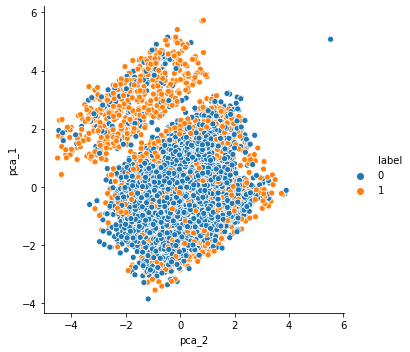

In [6]:
# train_x = train_x[['pca_0','pca_1','pca_2','um_0','um_1', "tsne_0", "tsne_1"]]
# test_x = test_x[['pca_0','pca_1','pca_2','um_0','um_1', "tsne_0", "tsne_1"]]

import matplotlib.pyplot as plt  
import seaborn as sns


plt_data = train_x.copy()
plt_data['label'] = train_y
sns.relplot(x="pca_2", y="pca_1", hue='label', data=plt_data)


In [7]:
pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 500)
display(train_x)
display(test_x)
display(train_y)

,age,campaign_connect_times,after_campaign_connect_day,before_campaign_connect_times,employment_rate,consumer_price_index,consumer_confidence_index,euducation_level_high,euducation_level_low,euducation_level_medium,job_employment,job_retired,job_student,job_unemployed,marital_divorced,marital_married,marital_single,marital_unknown,have_credit_card_no,have_credit_card_unknown,have_credit_card_yes,have_housing_loan_no,have_housing_loan_unknown,have_housing_loan_yes,have_personal_loan_no,have_personal_loan_unknown,have_personal_loan_yes,connect_method_cellular,connect_method_telephone,previous_connect_month_3.0,previous_connect_month_4.0,previous_connect_month_5.0,previous_connect_month_6.0,previous_connect_month_7.0,previous_connect_month_8.0,previous_connect_month_9.0,previous_connect_month_10.0,previous_connect_month_11.0,previous_connect_month_12.0,previous_connect_weekday_Friday,previous_connect_weekday_Monday,previous_connect_weekday_Thursday,previous_connect_weekday_Tuesday,previous_connect_weekday_Wednesday,last_campaign_outcomes_failure,last_campaign_outcomes_nonexistent,last_campaign_outcomes_success,pca_0,pca_1,pca_2,um_0,um_1
0,0.080239,-1.064683,-0.213269,-0.43274,-0.392897,-1.970646e-15,-0.267619,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0.132510,-0.310835,0.737579,16.318945,-7.101428
1,-1.618906,0.818125,-0.213269,-0.43274,-1.217788,-2.720046e-15,-1.479867,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.531800,-2.372487,-0.812977,7.342689,-9.769299
2,-1.139916,1.166980,-0.213269,-0.43274,0.946486,4.968248e-15,-0.222932,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,-1.119437,-0.550936,-1.206746,-0.101933,16.632938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19997,0.629506,0.213107,-0.213269,-0.43274,0.946486,-5.828671e-16,0.960388,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,-1.109278,1.096041,-0.028019,15.978269,0.906657
19998,1.226975,-1.064683,-0.213269,-0.43274,-1.522394,-3.386180e-15,-0.002723,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.605402,0.137023,1.718698,-0.436014,-1.050888
19999,0.629506,1.166980,-0.213269,-0.43274,0.946486,2.026157e-15,-0.425716,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,-1.256011,0.278673,0.265187,3.529915,14.209933


,age,campaign_connect_times,after_campaign_connect_day,before_campaign_connect_times,employment_rate,consumer_price_index,consumer_confidence_index,euducation_level_high,euducation_level_low,euducation_level_medium,job_employment,job_retired,job_student,job_unemployed,marital_divorced,marital_married,marital_single,marital_unknown,have_credit_card_no,have_credit_card_unknown,have_credit_card_yes,have_housing_loan_no,have_housing_loan_unknown,have_housing_loan_yes,have_personal_loan_no,have_personal_loan_unknown,have_personal_loan_yes,connect_method_cellular,connect_method_telephone,previous_connect_month_3.0,previous_connect_month_4.0,previous_connect_month_5.0,previous_connect_month_6.0,previous_connect_month_7.0,previous_connect_month_8.0,previous_connect_month_9.0,previous_connect_month_10.0,previous_connect_month_11.0,previous_connect_month_12.0,previous_connect_weekday_Friday,previous_connect_weekday_Monday,previous_connect_weekday_Thursday,previous_connect_weekday_Tuesday,previous_connect_weekday_Wednesday,last_campaign_outcomes_failure,last_campaign_outcomes_nonexistent,last_campaign_outcomes_success,pca_0,pca_1,pca_2,um_0,um_1
0,-0.994467,1.549194,-0.213269,-0.432740,0.946486,4.968248e-15,-0.222932,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-1.146730,-0.783553,-1.551005,-0.641276,14.143172
1,0.868993,-1.064683,-0.213269,2.308208,-1.217788,-1.026956e-15,1.205895,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2.126512,1.462204,0.723966,7.045860,3.752402
2,1.159064,0.213107,-0.213269,-0.432740,0.946486,-5.828671e-16,0.960388,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,-1.113836,1.229076,0.441030,-2.418440,-6.059942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19096,0.868993,-1.064683,-0.213269,2.308208,-1.217788,-3.774758e-15,-1.255759,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2.662469,-0.195529,1.650890,-1.624421,3.495118
19097,-0.855241,1.166980,-0.213269,-0.432740,0.614703,2.442491e-15,0.902449,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,-1.176333,0.062131,-1.434205,-6.580408,4.916867
19098,-0.470632,0.818125,-0.213269,-0.432740,0.946486,-5.828671e-16,0.960388,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,-1.039709,0.271261,-1.361753,-1.506434,6.836242


0        0
1        1
2        1
        ..
19997    0
19998    0
19999    0
Name: label, Length: 20000, dtype: int64

In [8]:
# 不平衡資料的處理

In [9]:
# 特別對評價指標去最佳化

# 建立評價指標

In [10]:
# Weighted Categroies Accuracy
def WCatAcc(pred, labe):
    pred = np.array(pred)
    labe = np.array(labe)
    # print('pred',pred.dtype, pred.shape, pred)
    # print('labe',labe.dtype, labe.shape, labe)
    assert (pred.shape == labe.shape)
    assert (pred.dtype == labe.dtype)
    positive_mask = (pred == labe)
    # print('positive_mask', positive_mask)
    n_true_positive = np.sum(pred[positive_mask])
    n_true_negative = np.sum(positive_mask)-n_true_positive
    n_positive_point = np.sum(labe)
    n_negative_point = labe.size - n_positive_point
    # print('TP: ', n_true_positive,
    #       'TN: ', n_true_negative,
    #       'P: ',  n_positive_point,
    #       'N: ', n_negative_point)
    score = (9*n_true_positive+1*n_true_negative) / \
        (9*n_positive_point+1*n_negative_point)
    # print(f'score: {score:.4f}')
    return score


WCatAcc([0, 0, 1, 1, 1, 0, 1], [0, 0, 1, 1, 1, 1, 0])

from scipy.optimize import minimize



# 建立模型

In [11]:
# 設定超參數
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss', # !!!!!
    'eta': 0.05, # learning rate
    'subsample': 0.8,  # 抽row
    'colsample_bytree': 0.8, # 抽col
    'min_child_weight': 10,  # 每個葉子至少要包含幾筆資料
    'max_depth': 12,  # 決策樹深度限制
    # 'random_state': 71,
}

In [12]:
# 驗證
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

dtest = xgb.DMatrix(test_x)
kfold_model_list = []
best_threshold_list = []
n_tree_limit_list = []
logloss_arr = []
wc_acc_arr = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=9912)
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random.randint(9999)+1)
for tr_idx, va_idx in kf.split(train_x, train_y):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    # -----------------------------------
    # 使用 xgboost
    # -----------------------------------

    # 將特徵和標籤轉換為 xgboost 的資料結構
    dtrain = xgb.DMatrix(tr_x, label=tr_y)
    dvalid = xgb.DMatrix(va_x, label=va_y)
    # dtrain = xgb.DMatrix(tr_x, label=tr_y, weight=tr_y*1+1)
    # dvalid = xgb.DMatrix(va_x, label=va_y, weight=va_y*1+1)

    # 在 watchlist 中組合訓練資料與驗證資料
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    # 進行訓練，將驗證資料代入模型中，一面訓練模型，一面監控分數的變化
    model = xgb.train(params, dtrain,
                      num_boost_round=1000,  # 決策樹數量限制
                      evals=watchlist,
                      early_stopping_rounds=10,  # 提前中止
                      verbose_eval=False,
                      )

    # 計算驗證資料的 logloss 分數
    va_pred = model.predict(dvalid)
    logloss_score = log_loss(va_y, va_pred)
    logloss_arr.append(logloss_score)
    print(f'logloss: {logloss_score:.4f}')

    # 尋找最佳解
    tr_pred = model.predict(dtrain)
    def WCatAcc_opt(x):
        return -WCatAcc(np.where(tr_pred > x, 1, 0), tr_y)
    result = minimize(WCatAcc_opt, x0=np.array([0.5]), method='Nelder-Mead')
    best_threshold = result['x'].item()

    pred_label = np.where(va_pred > best_threshold, 1, 0)
    best_score = WCatAcc(pred_label, va_y)
    wc_acc_arr.append(best_score)
    print(f'best_threshold: {best_threshold:.4f}, best_score: {best_score:.4f}, best_ntree_limit: {model.best_ntree_limit:.4f}')

    kfold_model_list.append(model)
    best_threshold_list.append(best_threshold)
    n_tree_limit_list.append(model.best_ntree_limit)

print('-------------------------------------------\n',
      'average logloss: {:.4f}, avg wc acc: {:.4f}'.format(np.mean(logloss_arr), np.mean(wc_acc_arr)))

# 集成多個驗證模型提交檔案
kfold_submission = []
for i in range(len(kfold_model_list)):
    # 以最佳決策樹的數量來進行預測
    pred = kfold_model_list[i].predict(dtest)#, iteration_range=(n_tree_limit_list[i]-5, n_tree_limit_list[i]+5))
    pred_label = np.where(pred > best_threshold_list[i], 1, 0)
    kfold_submission.append(pred_label)

# 建立提交用的檔案
kfold_submission = np.array(kfold_submission)
kfold_submission = kfold_submission.mean(axis=0)
kfold_submission = np.where(kfold_submission > 0.5, 1, 0)
submission = pd.DataFrame({'index': test['index'], 'label': kfold_submission})
submission.to_csv('../submission/submission_xgboost_02.csv', index=False)


logloss: 0.3140
best_threshold: 0.0942, best_score: 0.7396, best_ntree_limit: 78.0000
logloss: 0.3008
best_threshold: 0.0960, best_score: 0.7534, best_ntree_limit: 98.0000
logloss: 0.3061
best_threshold: 0.1047, best_score: 0.7587, best_ntree_limit: 110.0000
logloss: 0.2995
best_threshold: 0.0939, best_score: 0.7533, best_ntree_limit: 79.0000
logloss: 0.3133
best_threshold: 0.0978, best_score: 0.7396, best_ntree_limit: 79.0000
-------------------------------------------
 average logloss: 0.3067, avg wc acc: 0.7489


In [14]:
# 以全部資料重新訓練

# ntree_limit_avg = math.floor(np.mean(n_tree_limit_list))
# best_threshold_avg = np.mean(best_threshold_list)

# 將特徵和標籤轉換為 xgboost 的資料結構
dtest = xgb.DMatrix(test_x)
all_train = xgb.DMatrix(train_x, label=train_y)
# all_train = xgb.DMatrix(train_x, label=train_y, weight=train_y*1+1)

ensemble_submission = []
for i in range(32): # 總共要組合幾個模型(32還不錯)
    params['random_state'] = np.random.randint(9999)+1
    # model = xgb.train(params, all_train, num_boost_round=ntree_limit_avg+10)
    model = xgb.train(params, all_train, num_boost_round=np.random.randint(np.min(n_tree_limit_list),np.max(n_tree_limit_list)))
    
    # 尋找最佳解
    tr_pred = model.predict(all_train)
    def WCatAcc_opt(x):
        return -WCatAcc(np.where(tr_pred > x, 1, 0), train_y)
    result = minimize(WCatAcc_opt, x0=np.array([0.5]), method='Nelder-Mead')
    best_threshold = result['x'].item()
    
    pred = model.predict(dtest)
    pred_label = np.where(pred > best_threshold, 1, 0)
    ensemble_submission.append(pred_label)

# 建立提交用的檔案
ensemble_submission = np.array(ensemble_submission)
pd.DataFrame(ensemble_submission.transpose()).to_csv("ensemble.csv") # 看看
ensemble_submission = ensemble_submission.mean(axis=0)
ensemble_submission = np.where(ensemble_submission > 0.5, 1, 0)
submission = pd.DataFrame(
    {'index': test['index'], 'label': ensemble_submission})
submission.to_csv('../submission/submission_xgboost_03.csv', index=False)
